<div class="alert alert-success">
    <h1 align="center"> Face Recognition (Siamese Network)</h1>
</div>

## Introduction

<h6>Face Recognition:</h6> 
 - Many classes, but very few examples for each class.

## Topics

- Face Recognition
- Siamese Network
- Contrastive loss and Triplet loss
- Defining and implementing a new Dataset class.

## Libraries

In [0]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps   
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.utils
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

# from utils import to_var
# from data_utils import create_validation_data

use_gpu = torch.cuda.is_available()

from google.colab import drive
drive.mount('/content/gdrive' , force_remount = True)

Mounted at /content/gdrive


Helper methods

In [0]:
def get_model(model_name, pretrained=False):
    return models.__dict__[model_name](pretrained)

def imshow(img, mean, std, text=None, should_save=False):
    # convert from torch tensor to numpy array
    img_np = img.numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)
    
    # denormalize
    img_np = img_np * std + mean
    img_np = img_np.clip(0., 1.)
    
    # plot
    plt.axis("off")
    if text:
        plt.text(160, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(img_np)
    plt.show()


def show_image_pair(img1, img2, text=None):
    concat = torch.cat((img1.unsqueeze(0), img2.unsqueeze(0)), 0)
    imshow(torchvision.utils.make_grid(concat), text)

## Data

In [0]:
DATA_DIR = '/content/gdrive/My Drive/data_sets/att_faces'
train_dir = f'{DATA_DIR}/train'
valid_dir = f'{DATA_DIR}/test'

sz = 90
batch_size = 8
embed_size = 128
num_epochs = 200

cnn_name = 'resnet101'

### Statistics

- Average width = `92.00`
- Average height = `112.00`
- Mean: `[0.4415 0.4415 0.4415]`
- Std:  `[0.1854 0.1854 0.1854]`

In [0]:
images = [f for f in glob(f'{train_dir}/*/*.pgm')]   # training images
# images += [f for f in glob(f'{valid_dir}/*/*.pgm')]  # validation images

num_images = len(images)
avg_width, avg_height = 0.0, 0.0
for img_fname in tqdm(images, desc='Gathering statistics'):
    w, h = Image.open(img_fname).size
    avg_width += w
    avg_height += h
    
avg_width /= num_images
avg_height /= num_images

print('\n Average width: {:.2f}, Average height: {:.2f}'.format(avg_width, avg_height))

Gathering statistics: 100%|██████████| 320/320 [00:00<00:00, 1260.50it/s]


 Average width: 92.00, Average height: 112.00


In [0]:
mean = np.array([0., 0., 0.])
std = np.array([0., 0., 0.])

for img_fname in tqdm(images, desc='Gathering statistics'):
    img = np.array(Image.open(img_fname).convert('RGB'))
    mean += np.mean(img, axis=(0, 1))
    std += np.std(img, axis=(0, 1))

mean /= num_images
std /= num_images
print('\n')
print('Mean:', mean / 255.0)
print('Std:', std / 255.0)

Gathering statistics: 100%|██████████| 320/320 [00:00<00:00, 342.09it/s]



Mean: [0.44150626 0.44150626 0.44150626]
Std: [0.18544565 0.18544565 0.18544565]


### Dataset

In many problems, we need to define our own Dataset class. To define a new Dataset, you should:
1. Create a subclass of `torch.utils.data.Dataset`
2. Override the following three methods:
 - The constructor or `__init__()`: this method is required to initialize the dataset object.
 - The `__getitem__()` method: this methos enables us to access each training data using its index. In other words, we can use the dataset as a simple list or sequence.
 - The `__len__()` method: this method returns number of data in the dataset.

In [0]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self, imgs, transform=None):
        """ Constructor
        Inputs:
            imgs: a list of images and their corresponding labels
            transform: required transformations
        """
        self.imgs = imgs
        self.transform = transform
        if transform is None:
            self.transform = transforms.ToTensor()
        
    def __getitem__(self, index):
        # select the image with given index from dataset
        anchor, anchor_label = self.imgs[index] 
        
        # we need to make sure approx 50% of images are in the same class
        is_negative = random.random() < 0.5
        if is_negative:
            second = random.choice([img for img, label in self.imgs if label != anchor_label])
        else:
            second = random.choice([img for img, label in self.imgs if label == anchor_label])
        
        # read pair of images
        anchor_img = Image.open(anchor).convert('RGB')
        second_img = Image.open(second).convert('RGB')
        
        # perform given transformations (if any)
        if self.transform is not None:
            anchor_img = self.transform(anchor_img)
            second_img = self.transform(second_img)
        
        return anchor_img, second_img, torch.Tensor([int(is_negative)])
    
    def __len__(self):
        return len(self.imgs)

#### Training data

In [0]:
zoom = int((1.0 + random.random() / 10.0) * sz)  # up to 10 percent zoom
stats = ([0.50480222, 0.4073655, 0.37700788], [0.29478898, 0.25199998, 0.2384155])

tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.RandomCrop(sz),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomGrayscale(0.2),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# training data
face_dataset = datasets.ImageFolder(train_dir)
train_ds = SiameseNetworkDataset(face_dataset.imgs, transform=tfms)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True , num_workers=64)

# validation data
valid_face_dataset = datasets.ImageFolder(valid_dir)
valid_ds = SiameseNetworkDataset(valid_face_dataset.imgs, transform=tfms)
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=False , num_workers=64)

### Visualize dataset

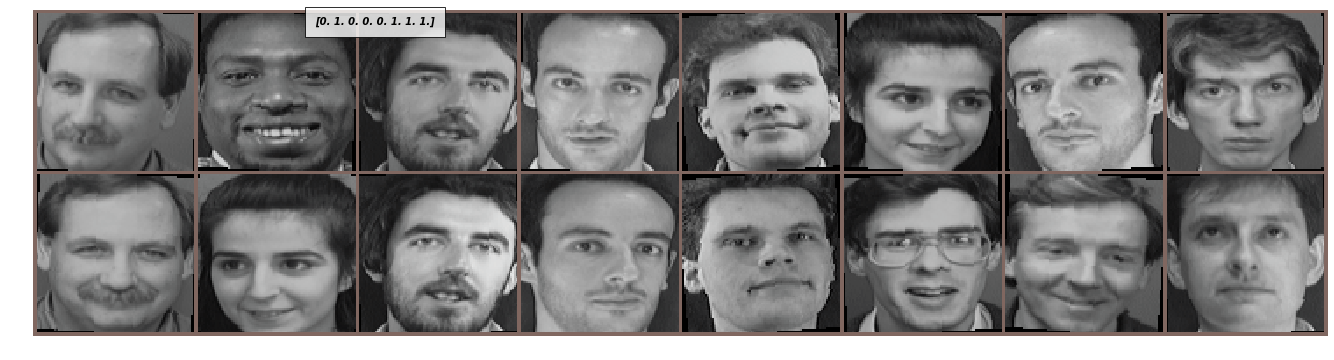

In [0]:
anchor_imgs, second_imgs, labels = next(iter(train_dl))
concat = torch.cat((anchor_imgs, second_imgs), 0)
labels = labels.numpy().T
plt.figure(figsize=(24, 6))
imshow(torchvision.utils.make_grid(concat, nrow=8),
       mean=stats[0], std=stats[1], text=f'{labels[0]}')

## Model: Siamese Netwok

In [0]:
class SiameseNetwork(nn.Module):
    
    def __init__(self, cnn, embed_size=128):
        super(SiameseNetwork, self).__init__()
        
        num_features = cnn.fc.in_features
        cnn.fc = nn.Linear(num_features, embed_size) 
        self.cnn = cnn

    def forward(self, x1, x2):
        f1 = self.cnn(x1)
        f2 = self.cnn(x2)
        return f1, f2

## Loss: Contrastive Loss

Given a pair of images and the corresponding label (0 or 1), the contrastive loss is defined as:
- if $y = 0$:
$$\lVert f(a) - f(b) \rVert^2$$
- if $y = 1$:
$$\max (\alpha - \lVert f(a) - f(b) \rVert, 0)^2$$

In [0]:
class ContrastiveLoss(nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss,self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

## Train

In [0]:
def train_step(model, train_dl, criterion, optimizer, scheduler=None):
    model.train()
    if scheduler:
        scheduler.step()
    
    N = len(train_dl.dataset)
    steps = N // train_dl.batch_size
    avg_loss = 0.0
    for i, (imgs0, imgs1, lbls) in enumerate(train_dl):
        imgs0, imgs1, lbls = to_var(imgs0), to_var(imgs1), to_var(lbls)
        
        # forward
        features0, features1 = model(imgs0, imgs1)
        
        # loss
        loss = criterion(features0, features1, lbls)
        avg_loss = (avg_loss * i + loss.data.item()) / (i + 1)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Training Step [{}/{}]: loss {:.5f}  ".format(i+1, steps+1, avg_loss))
    print()

    return model, avg_loss    


def validate_step(model, valid_dl, criterion):
    model.eval()
    
    N = len(valid_dl.dataset)
    steps = N // valid_dl.batch_size
    avg_loss = 0.0
    for i, (imgs0, imgs1, lbls) in enumerate(valid_dl):
        imgs0 = to_var(imgs0, volatile=True)
        imgs1 = to_var(imgs1, volatile=True)
        lbls = to_var(lbls, volatile=True)
        
        features0, features1 = model(imgs0, imgs1)
        loss = criterion(features0, features1, lbls)
        avg_loss = (avg_loss * i + loss.data.item()) / (i + 1)
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Validation Step [{}/{}]: loss {:.5f}  ".format(i+1, steps+1, avg_loss))
    print()
    
    return avg_loss


def train(model, train_dl, valid_dl, criterion, optimizer, scheduler=None, num_epochs=10):
    best_loss = float('inf')
    best_weights = model.state_dict().copy()
    
    train_loss_history, valid_loss_history = [], []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}\n--------')
        model, train_loss = train_step(model, train_dl, criterion, optimizer, scheduler)
        valid_loss = validate_step(model, valid_dl, criterion)
        
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_weights = model.state_dict().copy()
        print()
        
    loss_history = (train_loss_history, valid_loss_history)
    model.load_state_dict(best_weights)
#     torch.save(model.state_dict, f'/content/gdrive/My Drive/data_sets/att_faces/{cnn_name}-facereco-siamese-{num_epochs}.pth')
    return model, loss_history

In [0]:
# training and validation data
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

# model
cnn = get_model(cnn_name)
model = SiameseNetwork(cnn, embed_size)
if use_gpu: model = model.cuda()

# loss and optimizer
criterion = ContrastiveLoss()
if use_gpu: criterion = criterion.cuda()

optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.95)

In [0]:
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)
  
model, loss_hist = train(model, train_dl, valid_dl, criterion, 
                         optimizer, scheduler, num_epochs=20)

Epoch 0
--------
 Training Step [40/41]: loss 4.62038  
 Validation Step [2/11]: loss 16.63702  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


 Validation Step [10/11]: loss 13.08701  

Epoch 1
--------
 Training Step [40/41]: loss 2.90714  
 Validation Step [10/11]: loss 31.45694  

Epoch 2
--------
 Training Step [40/41]: loss 1.65276  
 Validation Step [10/11]: loss 2.55332  

Epoch 3
--------
 Training Step [40/41]: loss 1.25309  
 Validation Step [10/11]: loss 4.63750  

Epoch 4
--------
 Training Step [40/41]: loss 1.09957  
 Validation Step [10/11]: loss 6.37331  

Epoch 5
--------
 Training Step [40/41]: loss 1.02573  
 Validation Step [10/11]: loss 1.88783  

Epoch 6
--------
 Training Step [40/41]: loss 1.02034  
 Validation Step [10/11]: loss 1.32619  

Epoch 7
--------
 Training Step [40/41]: loss 1.08032  
 Validation Step [10/11]: loss 2.27663  

Epoch 8
--------
 Training Step [40/41]: loss 1.04008  
 Validation Step [10/11]: loss 2.67780  

Epoch 9
--------
 Training Step [40/41]: loss 1.04250  
 Validation Step [10/11]: loss 1.17107  

Epoch 10
--------
 Training Step [40/41]: loss 1.02610  
 Validation Step 

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SiameseNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


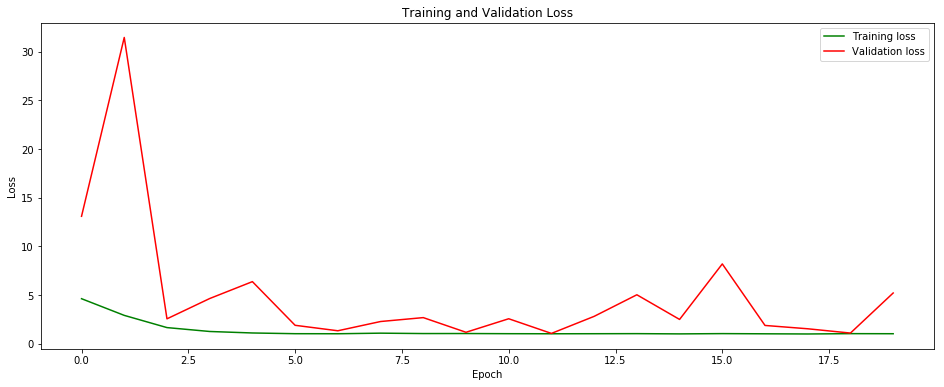

In [0]:
plt.figure(figsize=(16, 6))
plt.plot(loss_hist[0], 'g', label='Training loss')
plt.plot(loss_hist[1], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## Testing

In [0]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


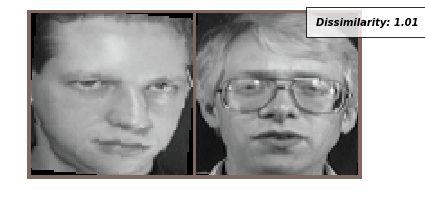

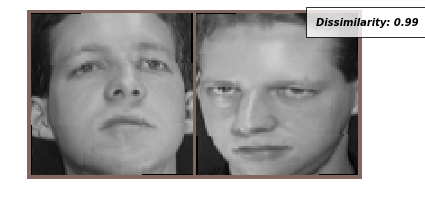

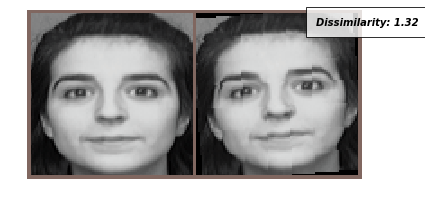

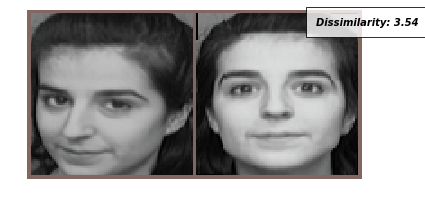

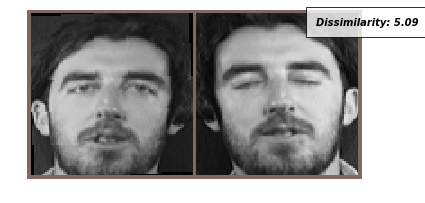

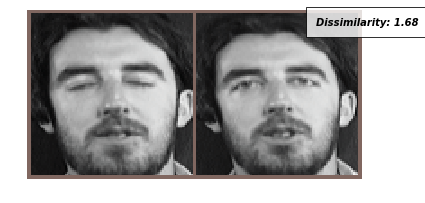

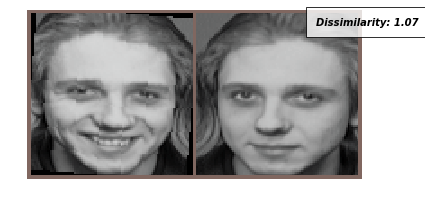

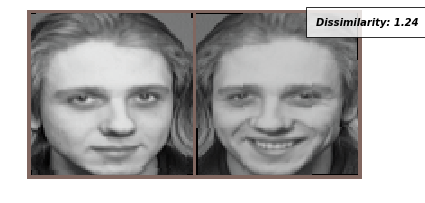

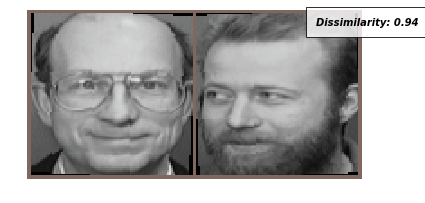

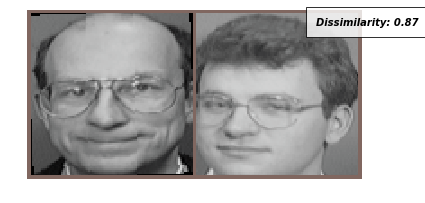

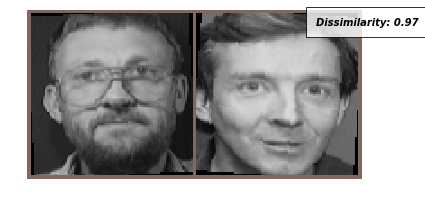

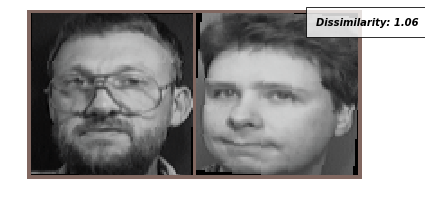

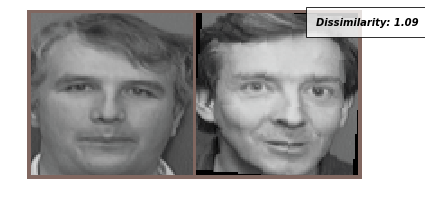

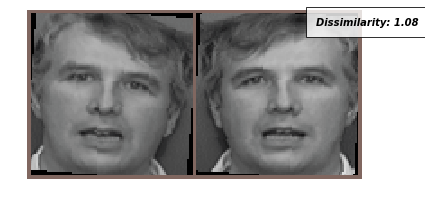

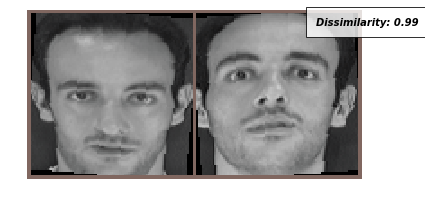

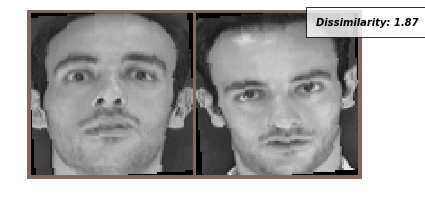

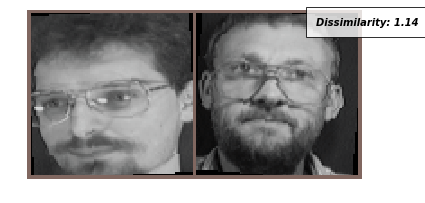

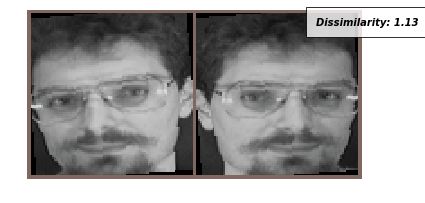

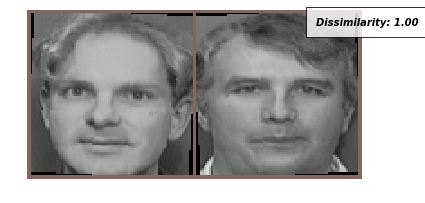

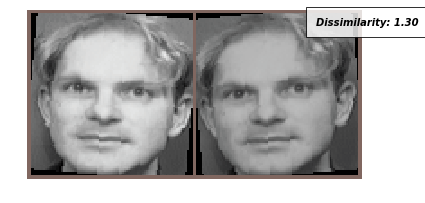

In [0]:
model.eval()

dataiter = iter(valid_dl)
for i in range(20):
    x0, x1, _ = next(dataiter)
    concat = torch.cat((x0, x1), 0)
    x0, x1 = to_var(x0, volatile=True), to_var(x1, volatile=True)
    f0, f1 = model(x0, x1)
    euclidean_distance = F.pairwise_distance(f0, f1)
    imshow(torchvision.utils.make_grid(concat),
           mean=stats[0], std=stats[1],
           text='Dissimilarity: {:.2f}'.format(euclidean_distance.cpu().data.numpy()[0]))